In [1]:
%matplotlib notebook
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy
import cdb_extras.xarray_support as cdbxr
from pyCDB import client
from scipy.signal import find_peaks
from elm_detection import *
from scipy.io import loadmat
cdb = client.CDBClient()

In [2]:
# signal = load_cdb_energy_signal(record_number, variant=variant)
# t_elms = load_cdb_telm_precalc(record_number)
# peaks, peaks_up, peaks_down = find_peaks_in_signal(signal, width=width, distance=distance, rel_height=rel_height)
# peaks_ds = peaks_as_xarray(peaks, signal)
# filtered_peaks_ds = filter_peaks(peaks_ds, gradient_threshold=gradient_threshold, energy_drop_threshold=energy_drop_threshold)
# peaks, _, _ = find_peaks_in_signal(signal)
# peaks_ds = peaks_as_xarray(peaks, signal)
# peaks_ds = filter_peaks(peaks_ds)
# peaks_ds

In [3]:
mat = loadmat("/compass/home/parr/Downloads/103372_for_elm_detection_JET.mat", squeeze_me=True)
time = mat["o"]["Wmhd_t"]
signal = mat["o"]["Wmhd"]
w_jet , t_elms_jet = load_michals_matfile_as_da("/compass/home/parr/Downloads/103372_for_elm_detection_JET.mat")


<IPython.core.display.Javascript object>


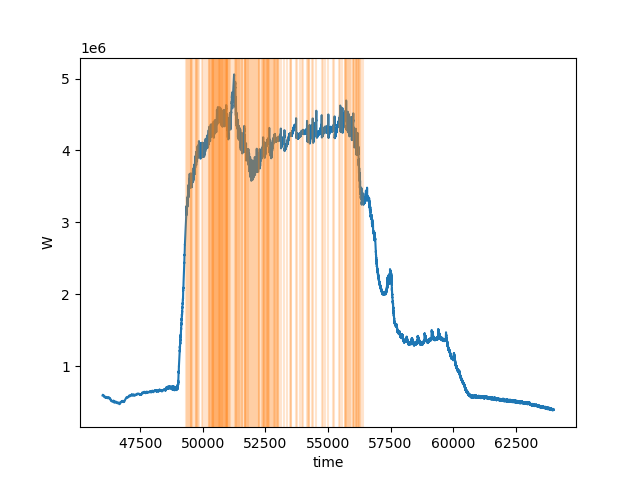

In [4]:
plt.figure()
w_jet.plot()
for t_elm in t_elms_jet:
    plt.axvline(t_elm, color="C1", alpha=0.2)

```diff
+Testing
-Thing
``` 

In [5]:
record_number = 18234
variant = "HIRES_ELM"
# This should be self explanatory /TODO
width=15
distance=5
rel_height=1

gradient_threshold=-100
energy_drop_threshold = 0.01

shots = [18232,18234,18238,18240,18248,18251,18257,18276,18433,18446,18447,18451,18533,18611,18235,18252,18263,18455]

print("For current high quality COMPASS shots.")
print(" ")
print("| Shot No. | No. of ELMs (W) | No. of ELMs (H_Alpha) | True Positives | False Positives | False Negatives|") 
print("----------------------------------------------------------------------------------------------------------")
for M in range(len(shots)):
    
    record_number = shots[M]
    
    signal = load_cdb_energy_signal(record_number, variant=variant)
    t_elms = load_cdb_telm_precalc(record_number)
    peaks, peaks_up, peaks_down = find_peaks_in_signal(signal, width=width, distance=distance, rel_height=rel_height)
    peaks_ds = peaks_as_xarray(peaks, signal)
    filtered_peaks_ds = filter_peaks(peaks_ds, gradient_threshold=gradient_threshold, energy_drop_threshold=energy_drop_threshold)
    
    
    TP = 0
    FP = 0
    FN = 0
    
    ELM_start_J = filtered_peaks_ds.t_start.data
    ELM_start_T = t_elms.data

    ELM_start_J1 = []
    ELM_start_T1 = []

    ELM_start_J2 = []
    ELM_start_T2 = []

    elm_candidates = list()

    for threshold_time in ELM_start_J:
        closest_through_time = None
        min_time_difference = float('inf')
        for through_time in ELM_start_T:
            time_difference = abs(through_time - threshold_time)
            if time_difference < min_time_difference:
                min_time_difference = time_difference
                closest_through_time = through_time
        if closest_through_time is not None:
            elm_candidates.append((threshold_time, closest_through_time))

    t_starts = [elm_c[0] for elm_c in elm_candidates]
    t_end = [elm_c[1] for elm_c in elm_candidates]
    
    for t_s, t_e in zip(t_starts, t_end):
        ELM_start_J1.append(t_s)
        ELM_start_T1.append(t_e)

    for i in range(len(ELM_start_J1)):
        if np.abs(ELM_start_J1[i]-ELM_start_T1[i]) < 0.5:
            ELM_start_J2.append(ELM_start_J1[i])
            ELM_start_T2.append(ELM_start_T1[i])
            TP+=1
    
    for j in range(len(ELM_start_J)):
        
        if ELM_start_J[j] not in ELM_start_J2:
            FP+=1
        
    for k in range(len(ELM_start_T)):
        
        if ELM_start_T[k] not in ELM_start_T2:
            FN+=1        
    
    
    Print = "| {:^8} | {:^15} | {:^21} | {:^14} | {:^15} | {:^14} |".format(record_number,len(filtered_peaks_ds.t_start.data),len(t_elms),TP,FP,FN)
    print(Print)

For current high quality COMPASS shots.
 
| Shot No. | No. of ELMs (W) | No. of ELMs (H_Alpha) | True Positives | False Positives | False Negatives|
----------------------------------------------------------------------------------------------------------
|  18232   |       67        |          79           |       63       |        4        |       16       |
|  18234   |       83        |          94           |       80       |        3        |       14       |
|  18238   |       24        |          25           |       19       |        5        |       6        |
|  18240   |       80        |          86           |       73       |        7        |       13       |
|  18248   |       53        |          59           |       50       |        3        |       9        |
|  18251   |       70        |          81           |       64       |        6        |       17       |
|  18257   |       69        |          77           |       64       |        5        |       13    

<IPython.core.display.Javascript object>


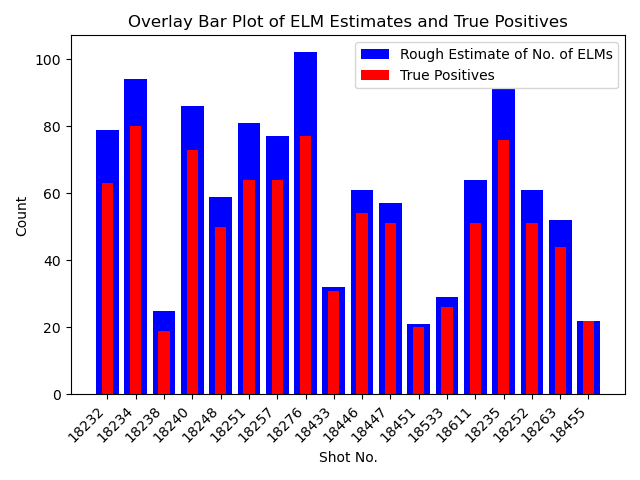

In [11]:

shots = ["18232","18234","18238","18240","18248","18251","18257","18276","18433","18446","18447","18451","18533","18611","18235","18252","18263","18455"]
y1 = [67, 83, 24, 80, 53, 70, 69, 90, 38, 63, 53, 24, 35, 62, 79, 55, 47, 43]
y2 = [63, 80, 19, 73, 50, 64, 64, 77, 31, 54, 51, 20, 26, 51, 76, 51, 44, 22]

x = np.arange(len(shots))  # Create an array of x-coordinates

plt.figure()
plt.bar(x, y1, color='b', width=0.8, label="No. of ELMS (W)")
plt.bar(x, y2, color='r', width=0.4, label="True Positives")
plt.xticks(x, shots, rotation=45, ha='right')  # Set custom tick labels
plt.xlabel("Shot No.")
plt.ylabel("Count")
plt.legend(loc="upper right")
plt.title("Overlay Bar Plot of No. of ELMS (W) and True Positives")
plt.tight_layout()
plt.show()

